# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [238]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [239]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [240]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [241]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [242]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        x0 = torch.sigmoid(x[:, 0]).unsqueeze(1)
        return torch.concat((x0, x[:, 1:]), dim=1)

In [243]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9, n_hidden_layers=2):
        super(VAE, self).__init__()
        assert n_hidden_layers >= 1, 'Number of hidden layers must be at least 1.'

        self.latent_dim = latent_dim
        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential()
        self.encoder.add_module('input_linear',nn.Linear(input_dim, hidden_dim))
        self.encoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.SiLU())
        self.encoder.add_module('output_linear',nn.Linear(hidden_dim, 2 * latent_dim)) # mean and variance

        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential()
        self.decoder.add_module('input_linear',nn.Linear(latent_dim, hidden_dim))
        self.decoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.SiLU())
        self.decoder.add_module('output_linear',nn.Linear(hidden_dim, input_dim))

        # self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        # x_recon = torch.sigmoid(x_recon)
        # x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        # loss_recon_bin = F.binary_cross_entropy(recon_x[:, 0], x[:, 0], reduction='mean')
        # loss_recon_mse = F.mse_loss(recon_x[:, 1:], x[:, 1:], reduction='mean')
        # loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        loss_recon = F.mse_loss(recon_x, x, reduction='mean')

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=None, #loss_recon_mse.detach(),
            loss_recon_bin=None, #loss_recon_bin.detach(),
            loss_recon=loss_recon.detach(),
            loss_kl=loss_kl.detach(),
        )

    def samples(self, n_samples = 1):
        """
        Gets samples from the latent space.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the latent space.
        """
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return self.decode(z)


## Data Tensors

In [244]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [245]:
columns = list(columns)
columns[0], columns[1] = columns[1], columns[0]

X_values = df_agg[columns].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

## Training Functions

In [246]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [247]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [248]:
def reconstruction_fig(model, data, scaler, scaled=True):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        data = data.cpu().numpy()

        if not scaled:
            data = scaler.inverse_transform(data)
            recon = scaler.inverse_transform(recon)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_samples = data.shape[0]

        fig, ax = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
        if n_samples == 1:
            ax = [ax]
        for i in range(n_samples):
            ax[i].plot(data[i], label='Original', color='blue', marker='o')
            ax[i].plot(recon[i], label='Reconstructed', color='blue', marker='o', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_ylim(0, 1)
        ax[0].legend()
        plt.tight_layout()
        return fig

In [249]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    device = next(model.parameters()).device
    batch_size = dataloader.batch_size

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = output.loss
        loss.backward(retain_graph=True)

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            # print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Recon', output.loss_recon.item(), global_step)
                # writer.add_scalar('Loss/Train/BCE', output.loss_recon_bin.item(), global_step)
                # writer.add_scalar('Loss/Train/MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [250]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    device = next(model.parameters()).device

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (Recon: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/Recon', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        inputs = next(iter(dataloader))
        writer.add_figure('Reconstruction', reconstruction_fig(model, inputs[:5], scaler, scaled=True), global_step=cur_step)

    return test_loss, test_recon_loss, test_kl_loss


In [251]:
def get_dataloaders(batch_size, X_train, X_test):
    train_loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        X_test,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def build_vae(options):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(
        input_dim=7,
        hidden_dim=options['hidden_dim'],
        latent_dim=options['latent_dim'],
        beta=options['beta'],
        alpha=options['alpha'],
        n_hidden_layers=options['n_hidden_layers']
        ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=options['learning_rate'],
        weight_decay=options['weight_decay'])
    writer = SummaryWriter(f'runs/{options["study_name"]}/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
    return model, optimizer, writer


def train_vae(options, model, optimizer, writer, train_loader, test_loader):
    prev_updates = 0
    best_loss = float('inf')
    best_losses = {}

    for epoch in range(options['num_epochs']):
        print(f'Epoch {epoch+1}/{options["num_epochs"]}')
        prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
        test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, writer=writer)
        if test_loss < best_loss:
            best_loss = test_loss
            best_losses = {
                'hparam/test_loss': test_loss,
                'hparam/recon_loss': test_recon_loss,
                'hparam/kl_loss': test_kl_loss,
            }
    writer.add_hparams(options, best_losses)
    writer.flush()
    writer.close()


def run_vae(options, X_train, X_test):
    model, optimizer, writer = build_vae(options)
    print(f"Number of parameters in the model: {count_parameters(model)}")

    train_loader, test_loader = get_dataloaders(options['batch_size'], X_train, X_test)
    train_vae(options, model, optimizer, writer, train_loader, test_loader)
    return model

## Model Training

In [285]:
options = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 1e-2,
    'num_epochs': 30,
    'latent_dim': 5,
    'hidden_dim': 12,
    'n_hidden_layers': 4,
    'beta': 0.006,
    'alpha': 0.0,
    'study_name': 'vae04',
    }

model = run_vae(options, X_train, X_test)

Number of parameters in the model: 1637
Epoch 1/30


  1%|          | 4/365 [00:00<00:09, 37.39it/s]

Step 0 (N samples: 0), Loss: 0.1774 (Recon: 0.1752, KL: 0.3721) Grad: 0.2978


 34%|███▍      | 125/365 [00:01<00:01, 155.75it/s]

Step 100 (N samples: 12,800), Loss: 0.0484 (Recon: 0.0479, KL: 0.0809) Grad: 0.0300


 63%|██████▎   | 229/365 [00:01<00:00, 167.43it/s]

Step 200 (N samples: 25,600), Loss: 0.0474 (Recon: 0.0473, KL: 0.0057) Grad: 0.0213


 91%|█████████ | 333/365 [00:02<00:00, 166.75it/s]

Step 300 (N samples: 38,400), Loss: 0.0455 (Recon: 0.0455, KL: 0.0110) Grad: 0.0317


Testing: 100%|██████████| 92/92 [00:00<00:00, 362.81it/s]


====> Test set loss: 0.0466 (Recon: 0.0464, KLD: 0.0442)
Epoch 2/30


 19%|█▊        | 68/365 [00:00<00:01, 162.35it/s]

Step 400 (N samples: 51,200), Loss: 0.0443 (Recon: 0.0429, KL: 0.2278) Grad: 0.0287


 42%|████▏     | 153/365 [00:00<00:01, 161.25it/s]

Step 500 (N samples: 64,000), Loss: 0.0267 (Recon: 0.0194, KL: 1.2215) Grad: 0.0542


 72%|███████▏  | 262/365 [00:01<00:00, 174.48it/s]

Step 600 (N samples: 76,800), Loss: 0.0204 (Recon: 0.0141, KL: 1.0555) Grad: 0.0175


100%|██████████| 365/365 [00:02<00:00, 166.59it/s]


Step 700 (N samples: 89,600), Loss: 0.0192 (Recon: 0.0132, KL: 1.0047) Grad: 0.0204


Testing: 100%|██████████| 92/92 [00:00<00:00, 355.90it/s]


====> Test set loss: 0.0187 (Recon: 0.0129, KLD: 0.9739)
Epoch 3/30


 24%|██▍       | 88/365 [00:00<00:01, 166.75it/s]

Step 800 (N samples: 102,400), Loss: 0.0201 (Recon: 0.0139, KL: 1.0339) Grad: 0.0234


 53%|█████▎    | 192/365 [00:01<00:01, 156.25it/s]

Step 900 (N samples: 115,200), Loss: 0.0194 (Recon: 0.0134, KL: 1.0008) Grad: 0.0197


 81%|████████  | 295/365 [00:01<00:00, 164.75it/s]

Step 1,000 (N samples: 128,000), Loss: 0.0175 (Recon: 0.0116, KL: 0.9902) Grad: 0.0110


Testing: 100%|██████████| 92/92 [00:00<00:00, 289.40it/s]


====> Test set loss: 0.0181 (Recon: 0.0124, KLD: 0.9397)
Epoch 4/30


  4%|▍         | 16/365 [00:00<00:04, 79.12it/s]

Step 1,100 (N samples: 140,800), Loss: 0.0201 (Recon: 0.0144, KL: 0.9440) Grad: 0.0338


 34%|███▍      | 125/365 [00:00<00:01, 155.47it/s]

Step 1,200 (N samples: 153,600), Loss: 0.0164 (Recon: 0.0101, KL: 1.0497) Grad: 0.0313


 62%|██████▏   | 227/365 [00:01<00:00, 164.52it/s]

Step 1,300 (N samples: 166,400), Loss: 0.0169 (Recon: 0.0112, KL: 0.9385) Grad: 0.0171


 90%|█████████ | 330/365 [00:02<00:00, 167.94it/s]

Step 1,400 (N samples: 179,200), Loss: 0.0191 (Recon: 0.0136, KL: 0.9228) Grad: 0.0256


Testing: 100%|██████████| 92/92 [00:00<00:00, 358.01it/s]


====> Test set loss: 0.0180 (Recon: 0.0118, KLD: 1.0324)
Epoch 5/30


 18%|█▊        | 65/365 [00:00<00:01, 162.69it/s]

Step 1,500 (N samples: 192,000), Loss: 0.0183 (Recon: 0.0123, KL: 0.9882) Grad: 0.0235


 46%|████▌     | 168/365 [00:01<00:01, 164.31it/s]

Step 1,600 (N samples: 204,800), Loss: 0.0176 (Recon: 0.0115, KL: 1.0181) Grad: 0.0153


 74%|███████▍  | 271/365 [00:01<00:00, 162.77it/s]

Step 1,700 (N samples: 217,600), Loss: 0.0178 (Recon: 0.0119, KL: 0.9886) Grad: 0.0246


100%|██████████| 365/365 [00:02<00:00, 163.66it/s]


Step 1,800 (N samples: 230,400), Loss: 0.0174 (Recon: 0.0118, KL: 0.9321) Grad: 0.0192


Testing: 100%|██████████| 92/92 [00:00<00:00, 381.47it/s]


====> Test set loss: 0.0178 (Recon: 0.0120, KLD: 0.9694)
Epoch 6/30


 27%|██▋       | 99/365 [00:00<00:01, 156.64it/s]

Step 1,900 (N samples: 243,200), Loss: 0.0173 (Recon: 0.0113, KL: 0.9972) Grad: 0.0310


 56%|█████▌    | 204/365 [00:01<00:00, 167.89it/s]

Step 2,000 (N samples: 256,000), Loss: 0.0207 (Recon: 0.0145, KL: 1.0261) Grad: 0.0205


 81%|████████  | 295/365 [00:01<00:00, 170.74it/s]

Step 2,100 (N samples: 268,800), Loss: 0.0183 (Recon: 0.0122, KL: 1.0105) Grad: 0.0187


Testing: 100%|██████████| 92/92 [00:00<00:00, 385.34it/s]


====> Test set loss: 0.0179 (Recon: 0.0122, KLD: 0.9366)
Epoch 7/30


 10%|▉         | 35/365 [00:00<00:01, 171.22it/s]

Step 2,200 (N samples: 281,600), Loss: 0.0199 (Recon: 0.0144, KL: 0.9262) Grad: 0.0220


 39%|███▉      | 143/365 [00:00<00:01, 165.38it/s]

Step 2,300 (N samples: 294,400), Loss: 0.0173 (Recon: 0.0116, KL: 0.9475) Grad: 0.0179


 64%|██████▎   | 232/365 [00:01<00:00, 171.82it/s]

Step 2,400 (N samples: 307,200), Loss: 0.0197 (Recon: 0.0139, KL: 0.9714) Grad: 0.0229


 93%|█████████▎| 339/365 [00:02<00:00, 169.89it/s]

Step 2,500 (N samples: 320,000), Loss: 0.0181 (Recon: 0.0121, KL: 1.0066) Grad: 0.0314


Testing: 100%|██████████| 92/92 [00:00<00:00, 366.32it/s]


====> Test set loss: 0.0178 (Recon: 0.0122, KLD: 0.9354)
Epoch 8/30


 19%|█▉        | 70/365 [00:00<00:02, 141.16it/s]

Step 2,600 (N samples: 332,800), Loss: 0.0165 (Recon: 0.0107, KL: 0.9561) Grad: 0.0196


 47%|████▋     | 173/365 [00:01<00:01, 159.26it/s]

Step 2,700 (N samples: 345,600), Loss: 0.0173 (Recon: 0.0114, KL: 0.9912) Grad: 0.0157


 75%|███████▍  | 273/365 [00:01<00:00, 161.28it/s]

Step 2,800 (N samples: 358,400), Loss: 0.0173 (Recon: 0.0116, KL: 0.9449) Grad: 0.0133


100%|██████████| 365/365 [00:02<00:00, 157.41it/s]


Step 2,900 (N samples: 371,200), Loss: 0.0184 (Recon: 0.0126, KL: 0.9745) Grad: 0.0163


Testing: 100%|██████████| 92/92 [00:00<00:00, 363.85it/s]


====> Test set loss: 0.0179 (Recon: 0.0120, KLD: 0.9806)
Epoch 9/30


 28%|██▊       | 104/365 [00:00<00:01, 165.19it/s]

Step 3,000 (N samples: 384,000), Loss: 0.0197 (Recon: 0.0140, KL: 0.9549) Grad: 0.0268


 56%|█████▋    | 206/365 [00:01<00:00, 160.81it/s]

Step 3,100 (N samples: 396,800), Loss: 0.0183 (Recon: 0.0122, KL: 1.0152) Grad: 0.0174


 84%|████████▍ | 306/365 [00:01<00:00, 159.07it/s]

Step 3,200 (N samples: 409,600), Loss: 0.0194 (Recon: 0.0136, KL: 0.9637) Grad: 0.0230


Testing: 100%|██████████| 92/92 [00:00<00:00, 352.93it/s]


====> Test set loss: 0.0179 (Recon: 0.0118, KLD: 1.0111)
Epoch 10/30


 10%|█         | 37/365 [00:00<00:02, 128.63it/s]

Step 3,300 (N samples: 422,400), Loss: 0.0166 (Recon: 0.0108, KL: 0.9529) Grad: 0.0275


 38%|███▊      | 139/365 [00:00<00:01, 160.38it/s]

Step 3,400 (N samples: 435,200), Loss: 0.0187 (Recon: 0.0125, KL: 1.0312) Grad: 0.0234


 67%|██████▋   | 244/365 [00:01<00:00, 166.45it/s]

Step 3,500 (N samples: 448,000), Loss: 0.0170 (Recon: 0.0112, KL: 0.9706) Grad: 0.0174


 90%|█████████ | 330/365 [00:02<00:00, 151.95it/s]

Step 3,600 (N samples: 460,800), Loss: 0.0202 (Recon: 0.0145, KL: 0.9607) Grad: 0.0238


Testing: 100%|██████████| 92/92 [00:00<00:00, 370.72it/s]


====> Test set loss: 0.0178 (Recon: 0.0118, KLD: 1.0084)
Epoch 11/30


 22%|██▏       | 82/365 [00:00<00:01, 164.41it/s]

Step 3,700 (N samples: 473,600), Loss: 0.0186 (Recon: 0.0127, KL: 0.9777) Grad: 0.0308


 45%|████▌     | 166/365 [00:01<00:01, 152.19it/s]

Step 3,800 (N samples: 486,400), Loss: 0.0185 (Recon: 0.0130, KL: 0.9269) Grad: 0.0417


 78%|███████▊  | 283/365 [00:01<00:00, 156.16it/s]

Step 3,900 (N samples: 499,200), Loss: 0.0177 (Recon: 0.0113, KL: 1.0701) Grad: 0.0318


100%|██████████| 365/365 [00:02<00:00, 152.81it/s]


Step 4,000 (N samples: 512,000), Loss: 0.0170 (Recon: 0.0109, KL: 1.0161) Grad: 0.0165


Testing: 100%|██████████| 92/92 [00:00<00:00, 397.31it/s]


====> Test set loss: 0.0177 (Recon: 0.0115, KLD: 1.0379)
Epoch 12/30


 28%|██▊       | 101/365 [00:00<00:01, 161.30it/s]

Step 4,100 (N samples: 524,800), Loss: 0.0192 (Recon: 0.0131, KL: 1.0040) Grad: 0.0374


 55%|█████▍    | 200/365 [00:01<00:01, 154.31it/s]

Step 4,200 (N samples: 537,600), Loss: 0.0181 (Recon: 0.0119, KL: 1.0240) Grad: 0.0142


 87%|████████▋ | 317/365 [00:02<00:00, 157.41it/s]

Step 4,300 (N samples: 550,400), Loss: 0.0167 (Recon: 0.0102, KL: 1.0888) Grad: 0.0146


Testing: 100%|██████████| 92/92 [00:00<00:00, 384.23it/s]


====> Test set loss: 0.0173 (Recon: 0.0109, KLD: 1.0647)
Epoch 13/30


 14%|█▍        | 51/365 [00:00<00:01, 169.66it/s]

Step 4,400 (N samples: 563,200), Loss: 0.0175 (Recon: 0.0112, KL: 1.0536) Grad: 0.0210


 38%|███▊      | 138/365 [00:00<00:01, 159.71it/s]

Step 4,500 (N samples: 576,000), Loss: 0.0171 (Recon: 0.0108, KL: 1.0610) Grad: 0.0148


 66%|██████▌   | 241/365 [00:01<00:00, 152.44it/s]

Step 4,600 (N samples: 588,800), Loss: 0.0171 (Recon: 0.0104, KL: 1.1213) Grad: 0.0143


 93%|█████████▎| 339/365 [00:02<00:00, 150.32it/s]

Step 4,700 (N samples: 601,600), Loss: 0.0194 (Recon: 0.0124, KL: 1.1661) Grad: 0.0194


Testing: 100%|██████████| 92/92 [00:00<00:00, 364.97it/s]


====> Test set loss: 0.0171 (Recon: 0.0105, KLD: 1.0963)
Epoch 14/30


 22%|██▏       | 82/365 [00:00<00:02, 139.26it/s]

Step 4,800 (N samples: 614,400), Loss: 0.0178 (Recon: 0.0112, KL: 1.1093) Grad: 0.0182


 51%|█████     | 186/365 [00:01<00:01, 163.46it/s]

Step 4,900 (N samples: 627,200), Loss: 0.0171 (Recon: 0.0100, KL: 1.1745) Grad: 0.0151


 75%|███████▌  | 275/365 [00:01<00:00, 171.61it/s]

Step 5,000 (N samples: 640,000), Loss: 0.0164 (Recon: 0.0097, KL: 1.1198) Grad: 0.0169


100%|██████████| 365/365 [00:02<00:00, 160.84it/s]


Step 5,100 (N samples: 652,800), Loss: 0.0167 (Recon: 0.0097, KL: 1.1640) Grad: 0.0142


Testing: 100%|██████████| 92/92 [00:00<00:00, 360.05it/s]


====> Test set loss: 0.0170 (Recon: 0.0099, KLD: 1.1742)
Epoch 15/30


 31%|███       | 112/365 [00:00<00:01, 149.99it/s]

Step 5,200 (N samples: 665,600), Loss: 0.0158 (Recon: 0.0091, KL: 1.1215) Grad: 0.0215


 58%|█████▊    | 210/365 [00:01<00:01, 153.86it/s]

Step 5,300 (N samples: 678,400), Loss: 0.0169 (Recon: 0.0100, KL: 1.1524) Grad: 0.0253


 85%|████████▍ | 310/365 [00:01<00:00, 163.28it/s]

Step 5,400 (N samples: 691,200), Loss: 0.0162 (Recon: 0.0084, KL: 1.2917) Grad: 0.0216


Testing: 100%|██████████| 92/92 [00:00<00:00, 342.33it/s]


====> Test set loss: 0.0167 (Recon: 0.0097, KLD: 1.1713)
Epoch 16/30


 17%|█▋        | 61/365 [00:00<00:02, 139.01it/s]

Step 5,500 (N samples: 704,000), Loss: 0.0177 (Recon: 0.0107, KL: 1.1590) Grad: 0.0141


 42%|████▏     | 153/365 [00:01<00:01, 170.69it/s]

Step 5,600 (N samples: 716,800), Loss: 0.0162 (Recon: 0.0092, KL: 1.1669) Grad: 0.0165


 67%|██████▋   | 243/365 [00:01<00:00, 167.75it/s]

Step 5,700 (N samples: 729,600), Loss: 0.0155 (Recon: 0.0083, KL: 1.2135) Grad: 0.0137


 96%|█████████▋| 352/365 [00:02<00:00, 172.22it/s]

Step 5,800 (N samples: 742,400), Loss: 0.0159 (Recon: 0.0086, KL: 1.2153) Grad: 0.0109


Testing: 100%|██████████| 92/92 [00:00<00:00, 345.44it/s]


====> Test set loss: 0.0161 (Recon: 0.0086, KLD: 1.2429)
Epoch 17/30


 24%|██▍       | 89/365 [00:00<00:01, 175.94it/s]

Step 5,900 (N samples: 755,200), Loss: 0.0138 (Recon: 0.0063, KL: 1.2498) Grad: 0.0153


 49%|████▉     | 178/365 [00:01<00:01, 160.42it/s]

Step 6,000 (N samples: 768,000), Loss: 0.0191 (Recon: 0.0114, KL: 1.2833) Grad: 0.0601


 76%|███████▋  | 279/365 [00:01<00:00, 157.60it/s]

Step 6,100 (N samples: 780,800), Loss: 0.0152 (Recon: 0.0077, KL: 1.2497) Grad: 0.0411


100%|██████████| 365/365 [00:02<00:00, 162.83it/s]


Step 6,200 (N samples: 793,600), Loss: 0.0174 (Recon: 0.0091, KL: 1.3686) Grad: 0.0186


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.52it/s]


====> Test set loss: 0.0157 (Recon: 0.0080, KLD: 1.2877)
Epoch 18/30


 33%|███▎      | 119/365 [00:00<00:01, 171.53it/s]

Step 6,300 (N samples: 806,400), Loss: 0.0152 (Recon: 0.0074, KL: 1.3016) Grad: 0.0235


 63%|██████▎   | 230/365 [00:01<00:00, 178.39it/s]

Step 6,400 (N samples: 819,200), Loss: 0.0164 (Recon: 0.0080, KL: 1.3844) Grad: 0.0310


 88%|████████▊ | 323/365 [00:01<00:00, 176.66it/s]

Step 6,500 (N samples: 832,000), Loss: 0.0170 (Recon: 0.0092, KL: 1.2915) Grad: 0.0440


Testing: 100%|██████████| 92/92 [00:00<00:00, 382.23it/s]


====> Test set loss: 0.0156 (Recon: 0.0077, KLD: 1.3203)
Epoch 19/30


 14%|█▎        | 50/365 [00:00<00:01, 166.73it/s]

Step 6,600 (N samples: 844,800), Loss: 0.0155 (Recon: 0.0077, KL: 1.2976) Grad: 0.0194


 42%|████▏     | 152/365 [00:00<00:01, 162.77it/s]

Step 6,700 (N samples: 857,600), Loss: 0.0157 (Recon: 0.0078, KL: 1.3183) Grad: 0.0180


 70%|███████   | 256/365 [00:01<00:00, 164.06it/s]

Step 6,800 (N samples: 870,400), Loss: 0.0162 (Recon: 0.0082, KL: 1.3387) Grad: 0.0207


 99%|█████████▊| 360/365 [00:02<00:00, 170.59it/s]

Step 6,900 (N samples: 883,200), Loss: 0.0155 (Recon: 0.0075, KL: 1.3412) Grad: 0.0315


Testing: 100%|██████████| 92/92 [00:00<00:00, 387.58it/s]


====> Test set loss: 0.0158 (Recon: 0.0075, KLD: 1.3789)
Epoch 20/30


 25%|██▍       | 90/365 [00:00<00:01, 162.33it/s]

Step 7,000 (N samples: 896,000), Loss: 0.0158 (Recon: 0.0079, KL: 1.3259) Grad: 0.0176


 54%|█████▍    | 197/365 [00:01<00:00, 170.57it/s]

Step 7,100 (N samples: 908,800), Loss: 0.0156 (Recon: 0.0081, KL: 1.2567) Grad: 0.0111


 79%|███████▊  | 287/365 [00:01<00:00, 170.09it/s]

Step 7,200 (N samples: 921,600), Loss: 0.0154 (Recon: 0.0077, KL: 1.2781) Grad: 0.0352


Testing: 100%|██████████| 92/92 [00:00<00:00, 376.59it/s]


====> Test set loss: 0.0158 (Recon: 0.0078, KLD: 1.3196)
Epoch 21/30


  0%|          | 0/365 [00:00<?, ?it/s]

Step 7,300 (N samples: 934,400), Loss: 0.0155 (Recon: 0.0074, KL: 1.3414) Grad: 0.0225


 34%|███▎      | 123/365 [00:00<00:01, 169.71it/s]

Step 7,400 (N samples: 947,200), Loss: 0.0163 (Recon: 0.0085, KL: 1.2962) Grad: 0.0313


 62%|██████▏   | 228/365 [00:01<00:00, 172.29it/s]

Step 7,500 (N samples: 960,000), Loss: 0.0146 (Recon: 0.0066, KL: 1.3301) Grad: 0.0222


 87%|████████▋ | 318/365 [00:01<00:00, 172.78it/s]

Step 7,600 (N samples: 972,800), Loss: 0.0149 (Recon: 0.0070, KL: 1.3161) Grad: 0.0157


Testing: 100%|██████████| 92/92 [00:00<00:00, 361.82it/s]


====> Test set loss: 0.0155 (Recon: 0.0078, KLD: 1.2950)
Epoch 22/30


 15%|█▌        | 55/365 [00:00<00:02, 145.45it/s]

Step 7,700 (N samples: 985,600), Loss: 0.0157 (Recon: 0.0079, KL: 1.2916) Grad: 0.0316


 44%|████▍     | 162/365 [00:01<00:01, 168.32it/s]

Step 7,800 (N samples: 998,400), Loss: 0.0154 (Recon: 0.0077, KL: 1.2798) Grad: 0.0184


 73%|███████▎  | 265/365 [00:01<00:00, 167.93it/s]

Step 7,900 (N samples: 1,011,200), Loss: 0.0159 (Recon: 0.0079, KL: 1.3276) Grad: 0.0125


100%|██████████| 365/365 [00:02<00:00, 160.11it/s]


Step 8,000 (N samples: 1,024,000), Loss: 0.0151 (Recon: 0.0070, KL: 1.3580) Grad: 0.0144


Testing: 100%|██████████| 92/92 [00:00<00:00, 371.12it/s]


====> Test set loss: 0.0157 (Recon: 0.0077, KLD: 1.3275)
Epoch 23/30


 28%|██▊       | 101/365 [00:00<00:01, 169.73it/s]

Step 8,100 (N samples: 1,036,800), Loss: 0.0143 (Recon: 0.0067, KL: 1.2686) Grad: 0.0353


 52%|█████▏    | 190/365 [00:01<00:01, 171.45it/s]

Step 8,200 (N samples: 1,049,600), Loss: 0.0166 (Recon: 0.0089, KL: 1.2725) Grad: 0.0307


 82%|████████▏ | 300/365 [00:01<00:00, 174.48it/s]

Step 8,300 (N samples: 1,062,400), Loss: 0.0156 (Recon: 0.0080, KL: 1.2557) Grad: 0.0312


Testing: 100%|██████████| 92/92 [00:00<00:00, 366.69it/s]


====> Test set loss: 0.0155 (Recon: 0.0075, KLD: 1.3389)
Epoch 24/30


  9%|▉         | 32/365 [00:00<00:02, 157.69it/s]

Step 8,400 (N samples: 1,075,200), Loss: 0.0154 (Recon: 0.0073, KL: 1.3475) Grad: 0.0103


 38%|███▊      | 137/365 [00:00<00:01, 171.05it/s]

Step 8,500 (N samples: 1,088,000), Loss: 0.0162 (Recon: 0.0077, KL: 1.4202) Grad: 0.0163


 62%|██████▏   | 226/365 [00:01<00:00, 170.56it/s]

Step 8,600 (N samples: 1,100,800), Loss: 0.0154 (Recon: 0.0071, KL: 1.3757) Grad: 0.0099


 91%|█████████ | 331/365 [00:01<00:00, 167.05it/s]

Step 8,700 (N samples: 1,113,600), Loss: 0.0176 (Recon: 0.0099, KL: 1.2928) Grad: 0.0303


Testing: 100%|██████████| 92/92 [00:00<00:00, 349.77it/s]


====> Test set loss: 0.0155 (Recon: 0.0073, KLD: 1.3648)
Epoch 25/30


 19%|█▊        | 68/365 [00:00<00:02, 146.88it/s]

Step 8,800 (N samples: 1,126,400), Loss: 0.0156 (Recon: 0.0076, KL: 1.3403) Grad: 0.0218


 47%|████▋     | 172/365 [00:01<00:01, 168.43it/s]

Step 8,900 (N samples: 1,139,200), Loss: 0.0160 (Recon: 0.0081, KL: 1.3194) Grad: 0.0266


 70%|███████   | 257/365 [00:01<00:00, 162.62it/s]

Step 9,000 (N samples: 1,152,000), Loss: 0.0147 (Recon: 0.0069, KL: 1.3071) Grad: 0.0103


100%|██████████| 365/365 [00:02<00:00, 156.87it/s]


Step 9,100 (N samples: 1,164,800), Loss: 0.0169 (Recon: 0.0088, KL: 1.3550) Grad: 0.0378


Testing: 100%|██████████| 92/92 [00:00<00:00, 367.90it/s]


====> Test set loss: 0.0154 (Recon: 0.0077, KLD: 1.2844)
Epoch 26/30


 28%|██▊       | 103/365 [00:00<00:01, 164.76it/s]

Step 9,200 (N samples: 1,177,600), Loss: 0.0151 (Recon: 0.0075, KL: 1.2708) Grad: 0.0251


 58%|█████▊    | 210/365 [00:01<00:00, 170.54it/s]

Step 9,300 (N samples: 1,190,400), Loss: 0.0155 (Recon: 0.0077, KL: 1.2995) Grad: 0.0238


 82%|████████▏ | 298/365 [00:01<00:00, 166.57it/s]

Step 9,400 (N samples: 1,203,200), Loss: 0.0158 (Recon: 0.0080, KL: 1.3041) Grad: 0.0421


Testing: 100%|██████████| 92/92 [00:00<00:00, 357.20it/s]


====> Test set loss: 0.0155 (Recon: 0.0077, KLD: 1.2951)
Epoch 27/30


  9%|▉         | 32/365 [00:00<00:02, 157.61it/s]

Step 9,500 (N samples: 1,216,000), Loss: 0.0157 (Recon: 0.0077, KL: 1.3376) Grad: 0.0155


 37%|███▋      | 134/365 [00:00<00:01, 159.06it/s]

Step 9,600 (N samples: 1,228,800), Loss: 0.0150 (Recon: 0.0066, KL: 1.3874) Grad: 0.0133


 65%|██████▍   | 237/365 [00:01<00:00, 169.26it/s]

Step 9,700 (N samples: 1,241,600), Loss: 0.0162 (Recon: 0.0076, KL: 1.4338) Grad: 0.0163


 94%|█████████▍| 343/365 [00:02<00:00, 169.45it/s]

Step 9,800 (N samples: 1,254,400), Loss: 0.0169 (Recon: 0.0089, KL: 1.3407) Grad: 0.0438


Testing: 100%|██████████| 92/92 [00:00<00:00, 347.48it/s]


====> Test set loss: 0.0156 (Recon: 0.0073, KLD: 1.3841)
Epoch 28/30


 18%|█▊        | 66/365 [00:00<00:01, 157.51it/s]

Step 9,900 (N samples: 1,267,200), Loss: 0.0172 (Recon: 0.0091, KL: 1.3493) Grad: 0.0109


 46%|████▌     | 167/365 [00:01<00:01, 162.90it/s]

Step 10,000 (N samples: 1,280,000), Loss: 0.0154 (Recon: 0.0071, KL: 1.3776) Grad: 0.0475


 75%|███████▍  | 272/365 [00:01<00:00, 165.37it/s]

Step 10,100 (N samples: 1,292,800), Loss: 0.0154 (Recon: 0.0073, KL: 1.3496) Grad: 0.0223


100%|██████████| 365/365 [00:02<00:00, 164.29it/s]


Step 10,200 (N samples: 1,305,600), Loss: 0.0155 (Recon: 0.0075, KL: 1.3401) Grad: 0.0223


Testing: 100%|██████████| 92/92 [00:00<00:00, 340.44it/s]


====> Test set loss: 0.0154 (Recon: 0.0074, KLD: 1.3296)
Epoch 29/30


 29%|██▉       | 105/365 [00:00<00:01, 170.39it/s]

Step 10,300 (N samples: 1,318,400), Loss: 0.0140 (Recon: 0.0061, KL: 1.3276) Grad: 0.0128


 55%|█████▍    | 199/365 [00:01<00:00, 181.97it/s]

Step 10,400 (N samples: 1,331,200), Loss: 0.0149 (Recon: 0.0067, KL: 1.3548) Grad: 0.0139


 86%|████████▌ | 314/365 [00:01<00:00, 179.90it/s]

Step 10,500 (N samples: 1,344,000), Loss: 0.0167 (Recon: 0.0084, KL: 1.3751) Grad: 0.0178


Testing: 100%|██████████| 92/92 [00:00<00:00, 391.01it/s]


====> Test set loss: 0.0154 (Recon: 0.0078, KLD: 1.2724)
Epoch 30/30


 10%|▉         | 35/365 [00:00<00:01, 167.94it/s]

Step 10,600 (N samples: 1,356,800), Loss: 0.0153 (Recon: 0.0072, KL: 1.3504) Grad: 0.0176


 40%|███▉      | 145/365 [00:00<00:01, 179.01it/s]

Step 10,700 (N samples: 1,369,600), Loss: 0.0158 (Recon: 0.0078, KL: 1.3382) Grad: 0.0276


 65%|██████▌   | 239/365 [00:01<00:00, 178.43it/s]

Step 10,800 (N samples: 1,382,400), Loss: 0.0143 (Recon: 0.0064, KL: 1.3149) Grad: 0.0206


 96%|█████████▌| 351/365 [00:01<00:00, 177.09it/s]

Step 10,900 (N samples: 1,395,200), Loss: 0.0180 (Recon: 0.0098, KL: 1.3794) Grad: 0.0241


Testing: 100%|██████████| 92/92 [00:00<00:00, 393.73it/s]


====> Test set loss: 0.0153 (Recon: 0.0074, KLD: 1.3190)


## Sampling

In [286]:
model.eval()
samples = model.samples(10000).to('cpu').detach().numpy()
samples_original_scale = scaler.inverse_transform(samples)

samples_original_scale = scaler.inverse_transform(samples)

samples_original_scale[samples_original_scale < 0] = 0
samples_original_scale[:,0] = samples_original_scale[:,0].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

df_samples.to_csv('./data_synthetic_vae.csv', index=False)

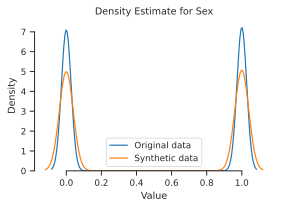

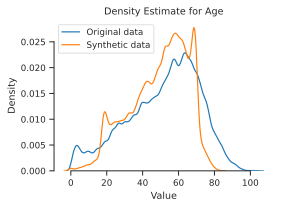

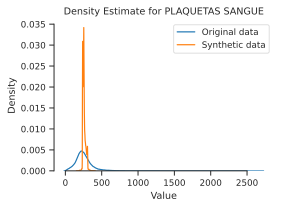

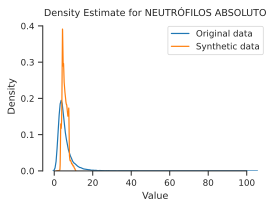

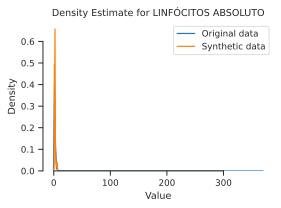

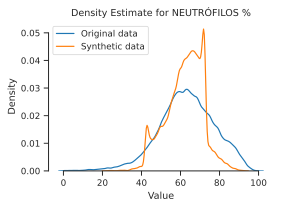

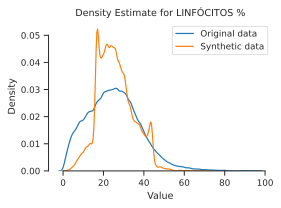

In [287]:
for i, t in enumerate(columns):
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax, bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax, bw_adjust=0.5)
    ax.set_title(f"Density Estimate for {t}")
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    sns.despine(trim=True)
    plt.savefig(f'./fig/VAE_dens_{i}.png')

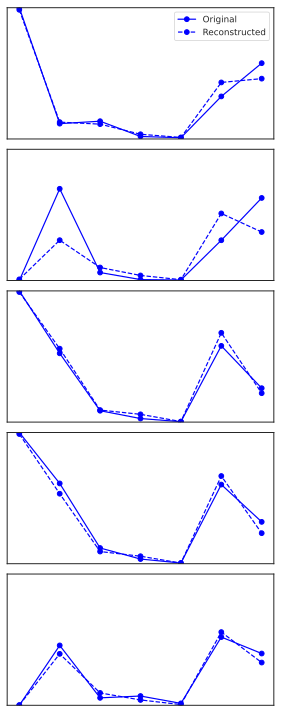

In [288]:
inputs = X_test[:5]
reconstruction_fig(model, inputs, scaler, scaled=True)
plt.savefig(f'./fig/VAE_recon.png')
plt.show()